<a href="https://colab.research.google.com/github/mrshamshir/Lung-Tumor-Segmentation/blob/main/Lung_Tumor_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install celluloid

In [2]:
%matplotlib notebook
from pathlib import Path
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from celluloid import Camera
from tqdm.notebook import tqdm
import cv2

In [3]:
import tarfile
my_tar = tarfile.open('/content/drive/MyDrive/Copy of Task06_Lung.tar')
my_tar.extractall('./my_folder') # specify which folder to extract to
my_tar.close()

In [4]:
# Inspect some sample data
root = Path("/content/my_folder/Task06_Lung/imagesTr")
label = Path("/content/my_folder/Task06_Lung/labelsTr/")

In [5]:
# Load a sample NIfTI and its corresponding label mask

def change_img_to_label_path(path):
    """
    Replaces imagesTr with labelsTr
    """
    parts = list(path.parts)  # get all directories whithin the path
    parts[parts.index("imagesTr")] = "labelsTr"  # Replace imagesTr with labelsTr
    return Path(*parts)  # Combine list back into a Path object


In [6]:
sample_path = list(root.glob("lung*"))[1]  # Choose a subject
sample_path_label = change_img_to_label_path(sample_path)

In [7]:
sample_path, sample_path_label

(PosixPath('/content/my_folder/Task06_Lung/imagesTr/lung_057.nii.gz'),
 PosixPath('/content/my_folder/Task06_Lung/labelsTr/lung_057.nii.gz'))

In [8]:
# Load NIfTI and extract image data
data = nib.load(sample_path)
label = nib.load(sample_path_label)

ct = data.get_fdata()
mask = label.get_fdata()

In [9]:
print(mask.shape)

(512, 512, 112)


In [10]:
# Find out the orientation
nib.aff2axcodes(data.affine)

('L', 'A', 'S')

In [11]:
# Inspect the loaded data with overlaid Ground Truth tumor segmentation using axial view
fig = plt.figure()
camera = Camera(fig)  # create the camera object from celluloid

for i in range(0, ct.shape[2], 2):  # axial view
    plt.imshow(ct[:,:,i], cmap="bone")
    mask_ = np.ma.masked_where(mask[:,:,i]==0, mask[:,:,i])
    plt.imshow(mask_, alpha=0.5, cmap="autumn")
    #plt.axis("off")
    camera.snap()  # Store the current slice
animation = camera.animate()  # create the animation




<IPython.core.display.Javascript object>

In [12]:
from IPython.display import HTML
HTML(animation.to_html5_video())  # convert the animation to a video


## Preprocessing

1. CT images have a fixed range from -1000 to 3071. **Thus we can normalize by dividing by 3071**
2. As we want to focus on lung tumors, we can crop away parts of the lower abdomen to reduce the complexity and help the network learn. As an example, we might skip the first 30 slices (from lower abdomen to the neck) (last axis)
3. As we want to tackle this task on a slice level (2D) and not on a subject level (3D) to reduce the computational cost we should store the preprocessed data as 2d files, because reading a single slice is much faster than loading the complete NIfTI file.
4. Resize the single slices and masks to (256, 256) (when resizing the mask, pass interpolation=cv2.INTER_NEAREST to the resize function to apply nearest neighbour interpolation)

Loop over all_files and apply the preprocessing steps. <br />

In the preprocessing loop, we need to create a directory for each subject containg the ct and label slices with identical names. <br />
E.g:
* 0/data/0.npy
* 0/masks/0.npy

we will store the last 6 subjects as validation data


In [13]:
all_files = list(root.glob("lung_*"))  # Get all subjects

In [14]:
len(all_files)

63

In [15]:
save_root = Path("/content/my_folder/Task06_Lung/Preprocessed")

for counter, path_to_ct_data in enumerate(tqdm(all_files)):

    path_to_label = change_img_to_label_path(path_to_ct_data)  # Get path to ground truth

    # Load and extract corresponding data
    ct_data = nib.load(path_to_ct_data).get_fdata()
    label_data = nib.load(path_to_label).get_fdata()

    # Crop volume and label. Remove the first 30 slices
    ct_data = ct_data[:,:,30:] / 3071
    label_data = label_data[:,:,30:]

    # Check if train or val data and create corresponding path
    if counter < 57:
        current_path = save_root/"train"/str(counter)
    else:
        current_path = save_root/"val"/str(counter)

    # Loop over the slices in the full volume and store the data and labels in the data/masks directory
    for i in range(ct_data.shape[-1]):
        slice = ct_data[:,:,i]
        mask = label_data[:,:,i]

        # Resize slice and label to common resolution to reduce training time
        slice = cv2.resize(slice, (256, 256))
        mask = cv2.resize(mask, (256, 256), interpolation=cv2.INTER_NEAREST)

        slice_path = current_path/"data"
        mask_path = current_path/"masks"
        slice_path.mkdir(parents=True, exist_ok=True)
        mask_path.mkdir(parents=True, exist_ok=True)

        np.save(slice_path/str(i), slice)
        np.save(mask_path/str(i), mask)




  0%|          | 0/63 [00:00<?, ?it/s]

## Validate preprocessed data
Take a look at our stored files and inspect if everything worked as expected

In [16]:
path = Path("/content/my_folder/Task06_Lung/Preprocessed/train/10")  # Select a subject. Check the folder if it exists


In [17]:
list(path.glob("*"))

[PosixPath('/content/my_folder/Task06_Lung/Preprocessed/train/10/masks'),
 PosixPath('/content/my_folder/Task06_Lung/Preprocessed/train/10/data')]

In [38]:
1# Choose a file and load slice + mask

file = "180.npy"
slice = np.load(path/"data"/file)
mask = np.load(path/"masks"/file)
print(mask.any())

False


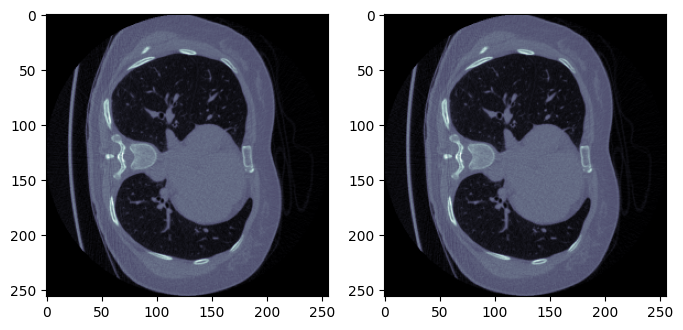

In [39]:
# Plot everything
# with gpu
# %matplotlib notebook
# with cpu
%matplotlib inline
fig, axis = plt.subplots(1, 2, figsize=(8, 8))
axis[0].imshow(slice, cmap="bone")
mask_ = np.ma.masked_where(mask==0, mask)
axis[1].imshow(slice, cmap="bone")
axis[1].imshow(mask_, cmap="autumn")


In [40]:
print(slice.min(), slice.max())

-0.33344187561055033 0.442282644089873


## Train

In [16]:
!pip install pytorch_lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.0/727.0 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 763.4/763.4 kB 39.1 MB/s eta 0:00:00


In [17]:
!pip uninstall imgaug
!pip install imgaug

Found existing installation: imgaug 0.4.0
Uninstalling imgaug-0.4.0:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/imgaug-0.4.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/imgaug/*
Proceed (Y/n)? y
  Successfully uninstalled imgaug-0.4.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.0/948.0 kB 5.9 MB/s eta 0:00:00


In [18]:
from pathlib import Path

import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import imgaug.augmenters as iaa
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from celluloid import Camera
from imgaug.augmentables.segmaps import SegmentationMapsOnImage

from dataset import LungDataset
from model import UNet

### Dataset Creation

In [19]:
seq = iaa.Sequential([
    iaa.Affine(translate_percent=(0.15),
               scale=(0.85, 1.15), # zoom in or out
               rotate=(-45, 45)#
               ),  # rotate up to 45 degrees
    iaa.ElasticTransformation()  # Elastic Transformations
                ])


In [20]:
# Create the dataset objects
train_path = Path("/content/my_folder/Task06_Lung/Preprocessed/train/")
val_path = Path("/content/my_folder/Task06_Lung/Preprocessed/val/")

train_dataset = LungDataset(train_path, seq)
val_dataset = LungDataset(val_path, None)

print(f"There are {len(train_dataset)} train images and {len(val_dataset)} val images")

There are 14127 train images and 1640 val images


### Oversampling to tackle strong class imbalance
Lung tumors are often very small, thus we need to make sure that our model does not learn a trivial solution which simply outputs 0 for all voxels.<br />
So, we will use oversampling to sample slices which contain a tumor more often.

In [48]:
# create a list containing only the class labels
target_list = []
for _, label in tqdm(train_dataset):
    # Check if mask contains a tumorous pixel:
    if np.any(label):
        target_list.append(1)
    else:
        target_list.append(0)

  0%|          | 0/14182 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)


In [49]:
# calculate the weight for each class
uniques = np.unique(target_list, return_counts=True)
uniques

(array([0, 1]), array([12675,  1507]))

In [50]:
fraction = uniques[1][0] / uniques[1][1]
fraction

8.410749834107499

In [51]:
weight_list = []
for target in target_list:
    if target == 0:
        weight_list.append(1)
    else:
        weight_list.append(fraction)

In [52]:
weight_list[:50]

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 8.410749834107499,
 1,
 1,
 1,
 8.410749834107499,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 8.410749834107499,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

In [53]:
# Finally we create the sampler which we can pass to the DataLoader.
sampler = torch.utils.data.sampler.WeightedRandomSampler(weight_list, len(weight_list))


In [21]:
batch_size = 8#TODO
num_workers = 2# TODO


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                           num_workers=num_workers, sampler=sampler)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)


In [55]:
# We can verify that our sampler works by taking a batch from the train loader and count how many labels are larger than zero
verify_sampler = next(iter(train_loader))  # Take one batch

In [56]:
(verify_sampler[1][:,0]).sum([1, 2]) > 0  # ~ half the batch size

tensor([ True,  True,  True, False, False,  True,  True, False])

### Loss

As this is a harder task to train we might try different loss functions:
We achieved best results by using the Binary Cross Entropy instead of the Dice Loss

In [22]:
# Full Segmentation Model
class TumorSegmentation(pl.LightningModule):
    def __init__(self):
        super().__init__()

        self.model = UNet()

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = torch.nn.BCEWithLogitsLoss()

    def forward(self, data):
        pred = self.model(data)
        return pred

    def training_step(self, batch, batch_idx):
        ct, mask = batch
        mask = mask.float()
        ct = ct.float()

        pred = self(ct)
        loss = self.loss_fn(pred, mask)

        # Logs
        self.log("Train Dice", loss)
        if batch_idx % 50 == 0:
            self.log_images(ct.cpu(), pred.cpu(), mask.cpu(), "Train")
        return loss


    def validation_step(self, batch, batch_idx):
        ct, mask = batch
        mask = mask.float()
        ct = ct.float()

        pred = self(ct)
        loss = self.loss_fn(pred, mask)

        # Logs
        self.log("Val Dice", loss)
        if batch_idx % 50 == 0:
            self.log_images(ct.cpu(), pred.cpu(), mask.cpu(), "Val")

        return loss


    def log_images(self, ct, pred, mask, name):

        results = []

        pred = pred > 0.5 # As we use the sigomid activation function, we threshold at 0.5


        fig, axis = plt.subplots(1, 2)
        axis[0].imshow(ct[0][0], cmap="bone")
        mask_ = np.ma.masked_where(mask[0][0]==0, mask[0][0])
        axis[0].imshow(mask_, alpha=0.6)
        axis[0].set_title("Ground Truth")

        axis[1].imshow(ct[0][0], cmap="bone")
        mask_ = np.ma.masked_where(pred[0][0]==0, pred[0][0])
        axis[1].imshow(mask_, alpha=0.6, cmap="autumn")
        axis[1].set_title("Pred")

        self.logger.experiment.add_figure(f"{name} Prediction vs Label", fig, self.global_step)



    def configure_optimizers(self):
        #We always need to return a list here (just pack our optimizer into one :))
        return [self.optimizer]



In [23]:
# Instanciate the model
model = TumorSegmentation()

In [65]:
# Create the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor='Val Dice',
    save_top_k=30,
    mode='min')

In [69]:
# Create the trainer

trainer = pl.Trainer(accelerator="auto", logger=TensorBoardLogger(save_dir="/content/drive/MyDrive/output/logs"), log_every_n_steps=1,
                     callbacks=checkpoint_callback,
                     max_epochs=30)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [70]:
type(train_loader)

torch.utils.data.dataloader.DataLoader

In [ ]:
trainer.fit(model, train_loader, val_loader,ckpt_path = "/content/drive/MyDrive/output/logs/lightning_logs/version_0/checkpoints/epoch=17-step=31914.ckpt")

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/output/logs/lightning_logs/version_0/checkpoints/epoch=17-step=31914.ckpt
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:337: UserWarning: The dirpath has changed from '/content/drive/MyDrive/output/logs/lightning_logs/version_0/checkpoints' to '/content/drive/MyDrive/output/logs/lightning_logs/version_1/checkpoints', therefore `best_model_score`, `kth_best_model_path`, `kth_value`, `last_model_path` and `best_k_models` won't be reloaded. Only `best_model_path` will be reloaded.
  warnings.warn(
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type              | Params
----------------------------------------------
0 | model   | UNet              | 7.8 M 
1 | loss_fn | BCEWithLogitsLoss | 0     
----------------------------------------------

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)
/usr/local/lib/python3.10/dist-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)


Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)
/usr/local/lib/python3.10/dist-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)


Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)
/usr/local/lib/python3.10/dist-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)


Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)
/usr/local/lib/python3.10/dist-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)


Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)
/usr/local/lib/python3.10/dist-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)


Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)
/usr/local/lib/python3.10/dist-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)


### Evaluation:
Let's evaluate the results

In [24]:
class DiceScore(torch.nn.Module):
    """
    class to compute the Dice Loss
    """
    def __init__(self):
        super().__init__()

    def forward(self, pred, mask):

        #flatten label and prediction tensors
        pred = torch.flatten(pred)
        mask = torch.flatten(mask)

        counter = (pred * mask).sum()  # Counter
        denum = pred.sum() + mask.sum()  # denominator
        dice = (2*counter)/denum

        return dice


In [26]:

model = TumorSegmentation.load_from_checkpoint("/content/drive/MyDrive/output/logs/lightning_logs/version_1/checkpoints/epoch=22-step=40779.ckpt",
                                               map_location=torch.device('cpu'))
model.eval();
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device);

In [27]:
preds = []
labels = []

for slice, label in tqdm(val_dataset):
    slice = torch.tensor(slice).float().to(device).unsqueeze(0)
    with torch.no_grad():
        pred = torch.sigmoid(model(slice))
    preds.append(pred.cpu().numpy())
    labels.append(label)

preds = np.array(preds)
labels = np.array(labels)

  0%|          | 0/1640 [00:00<?, ?it/s]

In [28]:
dice_score = DiceScore()(torch.from_numpy(preds), torch.from_numpy(labels).unsqueeze(0).float())
print(f"The Val Dice Score is: {dice_score}")

The Val Dice Score is: 0.7633702158927917


### Visualization


In [29]:
THRESHOLD = 0.5

In [30]:
import nibabel as nib
import cv2

In [31]:
subject = Path("/content/my_folder/Task06_Lung/imagesTs/lung_013.nii.gz")
ct = nib.load(subject).get_fdata() / 3071  # standardize
ct = ct[:,:,30:]  # crop

In [32]:
segmentation = []
label = []
scan = []

for i in range(ct.shape[-1]):
    slice = ct[:,:,i]
    slice = cv2.resize(slice, (256, 256))
    slice = torch.tensor(slice)
    scan.append(slice)
    slice = slice.unsqueeze(0).unsqueeze(0).float().to(device)

    with torch.no_grad():
        pred = model(slice)[0][0].cpu()
    pred = pred > THRESHOLD
    segmentation.append(pred)
    label.append(segmentation)


In [33]:
# Plotting the predicted segmentation (red)
%matplotlib notebook
fig = plt.figure()
camera = Camera(fig)  # create the camera object from celluloid

for i in range(0, len(scan), 2):  # Sagital view. Skip every second slice to reduce the video length
    plt.imshow(scan[i], cmap="bone")
    mask = np.ma.masked_where(segmentation[i]==0, segmentation[i])
    plt.imshow(mask, alpha=0.5, cmap="autumn")  # Use autumn colormap to get red segmentation

    plt.axis("off")
    camera.snap()  # Store the current slice
animation = camera.animate()  # create the animation

<IPython.core.display.Javascript object>

In [34]:
from IPython.display import HTML
HTML(animation.to_html5_video())  # convert the animation to a video
